# Citibike EDA

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
import datetime as dt
import random
from collections import Counter
from scipy import sparse
import pickle
import pandas.api.types as ptypes

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import patsy
from tqdm import tqdm
#import timeit.timeit
from fbprophet import Prophet
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from citibike_preprocessing import read_data_dask, count_missing_dates


Bad key "text.kerning_factor" on line 4 in
/Users/johnlee/opt/anaconda3/envs/metis/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Daily Rides

In [9]:
# read pickled dataframe
citibike_df = pd.read_pickle('citibike_df_preprocessed.pkl')

In [10]:
# drop some columns and reset index
citibike_df = citibike_df.drop(['replace_zeroes'], axis=1) #'ride_counts', 
citibike_df = citibike_df.reset_index(drop=True)
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts,ride_counts_clean
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,880.133333,2015,1,3,15,15
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,1499.818182,2015,1,4,22,22
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,432.266667,2015,1,5,15,15
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,693.666667,2015,1,6,27,27
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,669.000000,2015,1,0,27,27


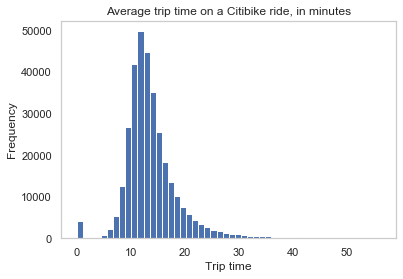

In [11]:
# plot distribution of average ride time in minutes
percentile_99 = np.percentile(citibike_df.mean_duration/60.0, 99)
plt.hist(citibike_df[citibike_df.mean_duration/60.0 < percentile_99].mean_duration/60.0, bins=50)
plt.title('Average trip time on a Citibike ride, in minutes')
plt.xlabel('Trip time')
plt.ylabel('Frequency');

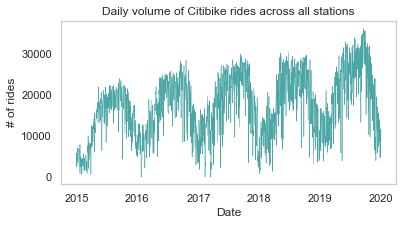

In [15]:
# total volume of citibike rides over time

#fig, ax = plt.subplots(nrows=1, ncols=1)
fig = plt.figure(figsize=(6,3));
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

plt.plot(citibike_df.groupby(['date']).agg({'ride_counts':'sum'}), color='teal', alpha=0.7, linewidth=0.5)

ax = plt.gca()

#ax.set_facecolor('whitesmoke')
plt.title('Daily volume of Citibike rides across all stations')
plt.xlabel('Date')
plt.ylabel('# of rides');

In [13]:
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts,ride_counts_clean
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,880.133333,2015,1,3,15,15
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,1499.818182,2015,1,4,22,22
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,432.266667,2015,1,5,15,15
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,693.666667,2015,1,6,27,27
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,669.000000,2015,1,0,27,27


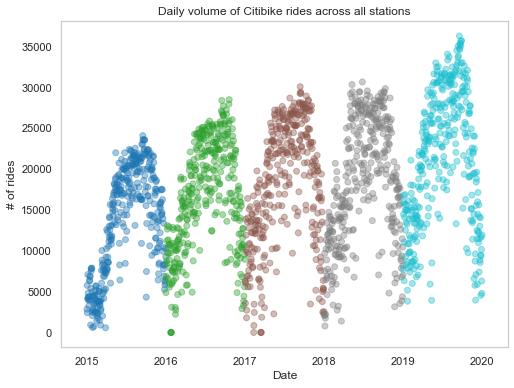

In [14]:
# total volume of citibike rides over time

#fig, ax = plt.subplots(nrows=1, ncols=1)
fig = plt.figure(figsize=(8,6));
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

plt.scatter(citibike_df.groupby(['date']).agg({'ride_counts':'sum'}).reset_index().date,
            citibike_df.groupby(['date']).agg({'ride_counts':'sum'}).reset_index().ride_counts, c=citibike_df.groupby(['date']).agg({'ride_counts':'sum'}).reset_index().date.dt.year*1.0, cmap='tab10', alpha=0.4, linewidth=1.0)

ax = plt.gca()

#ax.set_facecolor('whitesmoke')
plt.title('Daily volume of Citibike rides across all stations')
plt.xlabel('Date')
plt.ylabel('# of rides');

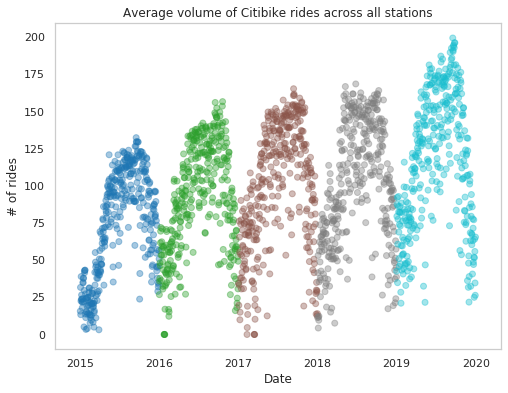

In [107]:
# average volume of citibike rides through time

#fig, ax = plt.subplots(nrows=1, ncols=1)
fig = plt.figure(figsize=(8,6));
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

plt.scatter(citibike_df.groupby(['date']).agg({'ride_counts':'mean'}).reset_index().date,
            citibike_df.groupby(['date']).agg({'ride_counts':'mean'}).reset_index().ride_counts, c=citibike_df.groupby(['date']).agg({'ride_counts':'mean'}).reset_index().date.dt.year*1.0, cmap='tab10', alpha=0.4, linewidth=1.0)

ax = plt.gca()

#ax.set_facecolor('whitesmoke')
plt.title('Average volume of Citibike rides across all stations')
plt.xlabel('Date')
plt.ylabel('# of rides');

In [16]:
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts,ride_counts_clean
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,880.133333,2015,1,3,15,15
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,1499.818182,2015,1,4,22,22
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,432.266667,2015,1,5,15,15
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,693.666667,2015,1,6,27,27
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,669.000000,2015,1,0,27,27


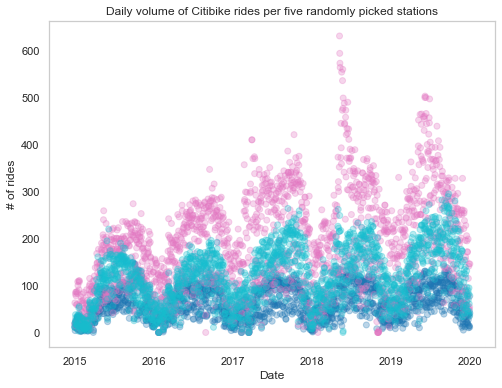

In [53]:
# daily volume of citibike rides per five randomly picked stations

#fig, ax = plt.subplots(nrows=1, ncols=1)
fig = plt.figure(figsize=(8,6));
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

sample_df = citibike_df.loc[citibike_df.station_id.isin(
    citibike_df.station_id.sample(n=3, random_state=19)),]

plt.scatter(sample_df.date,
            sample_df.ride_counts, 
            c=sample_df.station_id, cmap='tab10', alpha=0.3, linewidth=1.0)

ax = plt.gca()

#ax.set_facecolor('whitesmoke')
plt.title('Daily volume of Citibike rides per five randomly picked stations')
plt.xlabel('Date')
plt.ylabel('# of rides');

In [86]:
for i in sample_df.station_name.unique():
    print(i)

Pearl St & Hanover Square
W 33 St & 7 Ave
11 Ave & W 59 St


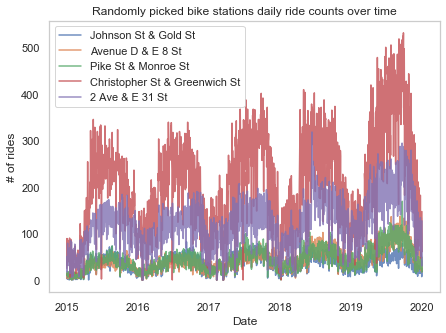

In [268]:
# randomly picked bike stations daily ride counts over time

#fig, ax = plt.subplots(nrows=1, ncols=1)
fig = plt.figure(figsize=(7,5));
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

sample_df = citibike_df.loc[citibike_df.station_id.isin(
    citibike_df.station_id.sample(n=5, random_state=87)),] #60 64 87

for i in sample_df.station_name.unique():
    plt.plot(sample_df.loc[sample_df.station_name == i].date,
             sample_df.loc[sample_df.station_name == i].ride_counts, 
             alpha=0.8, linewidth=1.5)
    
ax = plt.gca()

#ax.set_facecolor('whitesmoke')
plt.title('Randomly picked bike stations daily ride counts over time')
plt.xlabel('Date')
plt.ylabel('# of rides')
plt.legend([i for i in sample_df.station_name.unique()]);

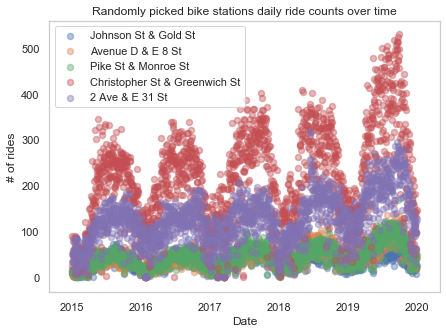

In [281]:
# randomly picked bike stations daily ride counts over time

#fig, ax = plt.subplots(nrows=1, ncols=1)
fig = plt.figure(figsize=(7,5));
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

sample_df = citibike_df.loc[citibike_df.station_id.isin(
    citibike_df.station_id.sample(n=5, random_state=87)),] #60 64 87

for i in sample_df.station_name.unique():
    plt.scatter(sample_df.loc[sample_df.station_name == i].date,
                sample_df.loc[sample_df.station_name == i].ride_counts, 
                alpha=0.4, linewidth=1.5)
    
ax = plt.gca()

#ax.set_facecolor('whitesmoke')
plt.title('Randomly picked bike stations daily ride counts over time')
plt.xlabel('Date')
plt.ylabel('# of rides')
plt.legend([i for i in sample_df.station_name.unique()]);

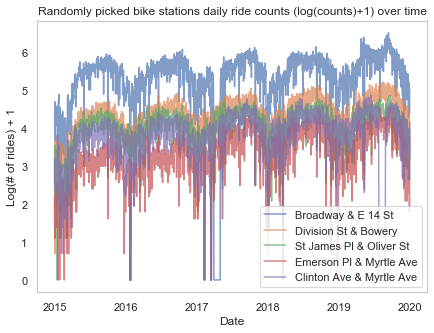

In [283]:
# randomly picked bike stations daily ride counts (log+1) over time

#fig, ax = plt.subplots(nrows=1, ncols=1)
fig = plt.figure(figsize=(7,5));
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

sample_df = citibike_df.loc[citibike_df.station_id.isin(
    citibike_df.station_id.sample(n=5, random_state=60)),] #60 64

for i in sample_df.station_name.unique():
    plt.plot(sample_df.loc[sample_df.station_name == i].date,
             np.log1p(sample_df.loc[sample_df.station_name == i].ride_counts), 
             alpha=0.7, linewidth=1.5)
    
ax = plt.gca()

#ax.set_facecolor('whitesmoke')
plt.title('Randomly picked bike stations daily ride counts (log(counts)+1) over time')
plt.xlabel('Date')
plt.ylabel('Log(# of rides) + 1')
plt.legend([i for i in sample_df.station_name.unique()]);

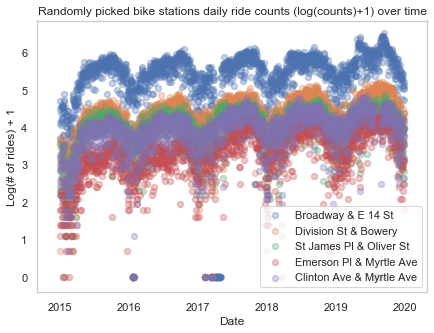

In [277]:
# randomly picked bike stations daily ride counts (log+1) over time

#fig, ax = plt.subplots(nrows=1, ncols=1)
fig = plt.figure(figsize=(7,5));
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

sample_df = citibike_df.loc[citibike_df.station_id.isin(
    citibike_df.station_id.sample(n=5, random_state=60)),] #60 64

for i in sample_df.station_name.unique():
    plt.scatter(sample_df.loc[sample_df.station_name == i].date,
                np.log1p(sample_df.loc[sample_df.station_name == i].ride_counts), 
                alpha=0.3, linewidth=1.5)
    
ax = plt.gca()

#ax.set_facecolor('whitesmoke')
plt.title('Randomly picked bike stations daily ride counts (log(counts)+1) over time')
plt.xlabel('Date')
plt.ylabel('Log(# of rides) + 1')
plt.legend([i for i in sample_df.station_name.unique()]);

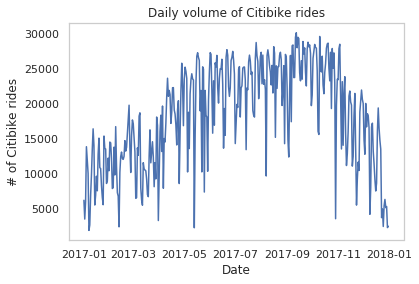

In [8]:
# plot daily ride counts across all stations for a particular year
plt.plot(citibike_df[citibike_df.year == 2017].groupby(['date']).agg({'ride_counts_clean':'sum'}))
plt.title('Daily volume of Citibike rides')
plt.xlabel('Date')
plt.ylabel('# of Citibike rides');

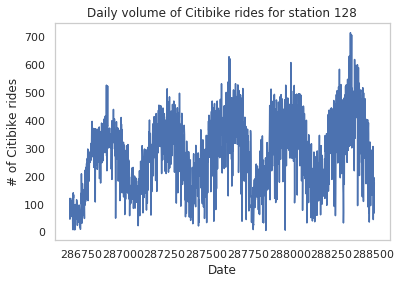

In [10]:
# plot daily ride counts for a specific station
plt.plot(citibike_df[citibike_df.station_id == 497].ride_counts_clean)
plt.title('Daily volume of Citibike rides for station 128')
plt.xlabel('Date')
plt.ylabel('# of Citibike rides');

In [11]:
# check if there are any missing dates in dataframe
pd.date_range(start = '2015-01-01', end = '2019-12-31').difference(citibike_df.date)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [12]:
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts_clean
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,880.133333,2015,1,3,15
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,1499.818182,2015,1,4,22
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,432.266667,2015,1,5,15
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,693.666667,2015,1,6,27
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,669.000000,2015,1,0,27


In [18]:
# top stations in terms of daily average volume of bike rides in 2019
citibike_df[(citibike_df.year == 2019)].groupby(['station_id', 'station_name'])['ride_counts_clean'].mean().round(1).sort_values(ascending=False).head(20)

station_id  station_name                     
519         Pershing Square North                429.0
497         E 17 St & Broadway                   333.6
435         W 21 St & 6 Ave                      318.6
402         Broadway & E 22 St                   310.8
285         Broadway & E 14 St                   309.6
426         West St & Chambers St                289.4
499         Broadway & W 60 St                   282.6
358         Christopher St & Greenwich St        277.8
514         12 Ave & W 40 St                     272.1
459         W 20 St & 11 Ave                     265.7
379         W 31 St & 7 Ave                      236.7
151         Cleveland Pl & Spring St             233.1
491         E 24 St & Park Ave S                 231.0
359         E 47 St & Park Ave                   227.1
504         1 Ave & E 15 St                      226.2
492         W 33 St & 7 Ave                      225.2
281         Grand Army Plaza & Central Park S    220.6
168         W 18 St

In [19]:
# select stations 
citibike_df[citibike_df.station_id.isin([491, 379, 217])][['station_id', 'station_name']].drop_duplicates()

,station_id,station_name
29216,217,Old Fulton St
178948,379,W 31 St & 7 Ave
279378,491,E 24 St & Park Ave S


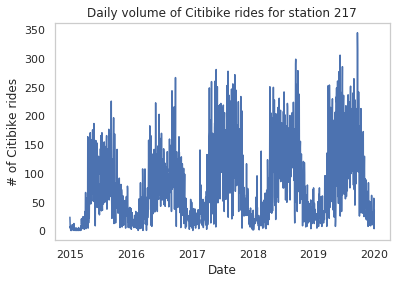

In [52]:
# plot daily ride counts for Old Fulton St station (Brooklyn)
plt.plot(citibike_df[citibike_df.station_id == 217].date,
         citibike_df[citibike_df.station_id == 217].ride_counts_clean)
plt.title('Daily volume of Citibike rides for station 217')
plt.xlabel('Date'), plt.ylabel('# of Citibike rides');

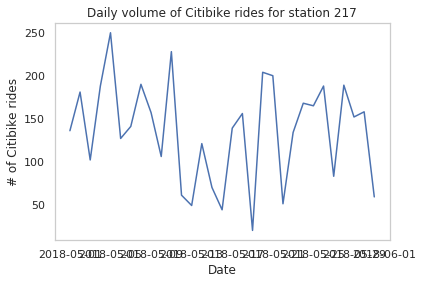

In [77]:
# look into specific peaks for station 217
plt.plot(citibike_df[(citibike_df.station_id == 217) & 
                     (citibike_df.year == 2018) & 
                     (citibike_df.month > 4) & 
                     (citibike_df.month < 6)].date,
         citibike_df[(citibike_df.station_id == 217) & 
                     (citibike_df.year == 2018) &
                     (citibike_df.month > 4) & 
                     (citibike_df.month < 6)].ride_counts_clean)
plt.title('Daily volume of Citibike rides for station 217')
plt.xlabel('Date'), plt.ylabel('# of Citibike rides');

In [91]:
# inspect the peaks for station 217
citibike_df[(citibike_df.station_id == 217) & 
            (citibike_df.year == 2018) & 
            (citibike_df.month > 4) & 
            (citibike_df.month < 10) &
            (citibike_df.ride_counts_clean > 220)]

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts_clean
43218,2018-05-05,217,Old Fulton St,40.702772,-73.993836,1581.232000,2018,5,5,250
43224,2018-05-11,217,Old Fulton St,40.702772,-73.993836,1588.495614,2018,5,4,228
43253,2018-06-09,217,Old Fulton St,40.702772,-73.993836,10223.142857,2018,6,5,231
43282,2018-07-08,217,Old Fulton St,40.702772,-73.993836,1455.830579,2018,7,6,242
43302,2018-07-28,217,Old Fulton St,40.702772,-73.993836,1444.599099,2018,7,5,222
43338,2018-09-02,217,Old Fulton St,40.702772,-73.993836,1609.723214,2018,9,6,224
43351,2018-09-15,217,Old Fulton St,40.702772,-73.993836,1441.603448,2018,9,5,290
43352,2018-09-16,217,Old Fulton St,40.702772,-73.993836,1614.377926,2018,9,6,299
43358,2018-09-22,217,Old Fulton St,40.702772,-73.993836,1395.666667,2018,9,5,255
43365,2018-09-29,217,Old Fulton St,40.702772,-73.993836,1474.035842,2018,9,5,279


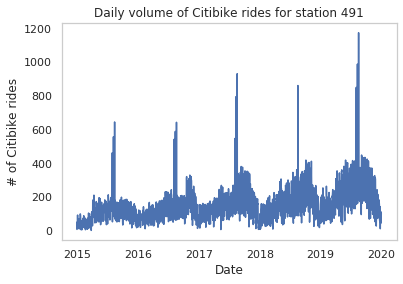

In [62]:
# plot daily ride counts for E 24 St & Park Ave S station
plt.plot(citibike_df[citibike_df.station_id == 491].date,
         citibike_df[citibike_df.station_id == 491].ride_counts_clean)
plt.title('Daily volume of Citibike rides for station 491')
plt.xlabel('Date'), plt.ylabel('# of Citibike rides');

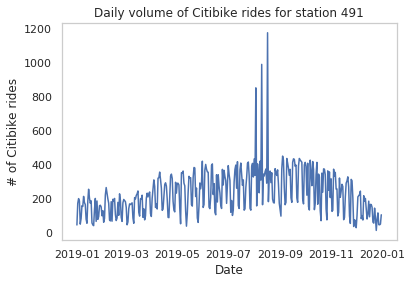

In [64]:
# inspect the peaks for station 491
plt.plot(citibike_df[(citibike_df.station_id == 491) & (citibike_df.year == 2019)].date,
         citibike_df[(citibike_df.station_id == 491) & (citibike_df.year == 2019)].ride_counts_clean)
plt.title('Daily volume of Citibike rides for station 491 in 2019')
plt.xlabel('Date'), plt.ylabel('# of Citibike rides');

In [101]:
# inspect the peaks for station 491
#citibike_df[(citibike_df.station_id == 491) & (citibike_df.ride_counts_clean > 500)]

# inspect the peaks for station 491
citibike_df[(citibike_df.station_id == 491) & 
            (citibike_df.year == 2017) & 
            (citibike_df.month > 7) &  
            (citibike_df.month < 9) &
            (citibike_df.ride_counts_clean > 400)]

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts_clean
384407,2017-08-05,491,E 24 St & Park Ave S,40.740964,-73.986022,1698.895795,2017,8,5,547
384414,2017-08-12,491,E 24 St & Park Ave S,40.740964,-73.986022,1606.586164,2017,8,5,795
384421,2017-08-19,491,E 24 St & Park Ave S,40.740964,-73.986022,1388.678840,2017,8,5,931


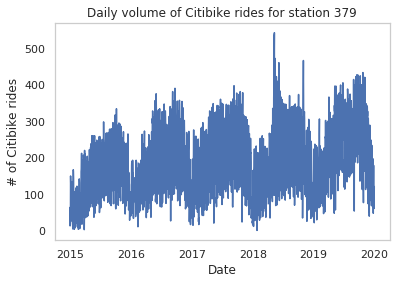

In [69]:
# plot daily ride counts for W 31 St & 7 Ave station
plt.plot(citibike_df[citibike_df.station_id == 379].date,
         citibike_df[citibike_df.station_id == 379].ride_counts_clean)
plt.title('Daily volume of Citibike rides for station 379')
plt.xlabel('Date'), plt.ylabel('# of Citibike rides');

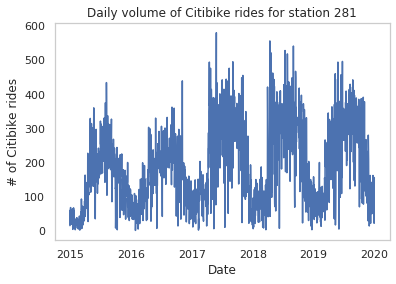

In [53]:
# plot daily ride counts for Grand Army Plaza & Central Park station
plt.plot(citibike_df[citibike_df.station_id == 281].date,
         citibike_df[citibike_df.station_id == 281].ride_counts_clean)
plt.title('Daily volume of Citibike rides for station 281')
plt.xlabel('Date'), plt.ylabel('# of Citibike rides');

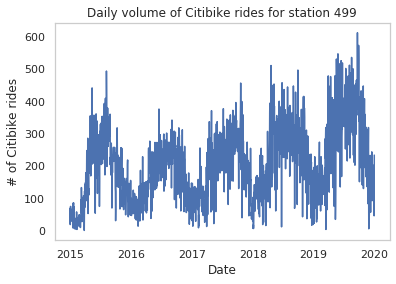

In [36]:
# plot daily ride counts for Broadway & W 60 St station
plt.plot(citibike_df[citibike_df.station_id == 499].date,
         citibike_df[citibike_df.station_id == 499].ride_counts_clean)
plt.title('Daily volume of Citibike rides for station 499')
plt.xlabel('Date'), plt.ylabel('# of Citibike rides');

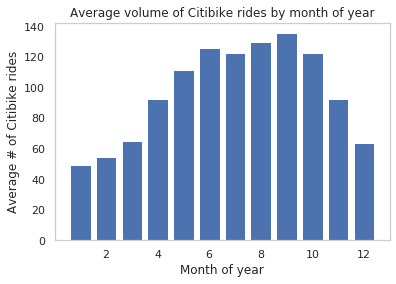

In [209]:
# average volume of citibike rides by month of year
citibike_monthly = citibike_df.groupby(['month'])['ride_counts_clean'].mean().reset_index()
plt.bar(np.array(citibike_monthly.month), np.array(citibike_monthly.ride_counts_clean))
plt.title('Average volume of Citibike rides by month of year')
plt.xlabel('Month of year')
plt.ylabel('Average # of Citibike rides');

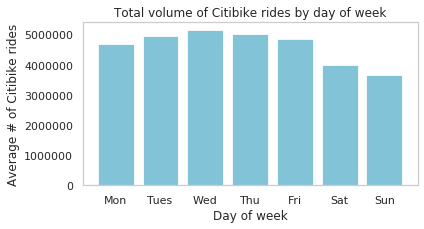

In [19]:
# total volume of citibike rides by day of week
plt.figure(figsize=(6,3))
citibike_daily = citibike_df.groupby(['day_of_week'])['ride_counts_clean'].sum().reset_index()
plt.bar(np.array(['Mon','Tues','Wed','Thu','Fri','Sat','Sun']), np.array(citibike_daily.ride_counts_clean), color='c', alpha=0.8)
plt.title('Total volume of Citibike rides by day of week')
plt.xlabel('Day of week')
plt.ylabel('Average # of Citibike rides');

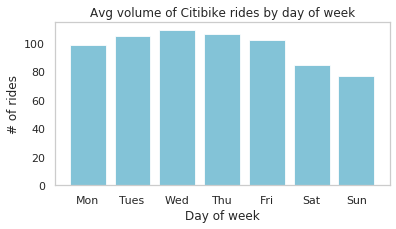

In [46]:
# average volume of citibike rides by day of week

citibike_daily = citibike_df.groupby(['day_of_week'])['ride_counts_clean'].mean().reset_index()

#fig, ax = plt.subplots(nrows=1, ncols=1)

fig = plt.figure(figsize=(6,3));
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

plt.bar(np.array(['Mon','Tues','Wed','Thu','Fri','Sat','Sun']), np.array(citibike_daily.ride_counts_clean), color='c', alpha=0.8)

ax = plt.gca()

#ax.set_facecolor('whitesmoke')
plt.title('Avg volume of Citibike rides by day of week')
plt.xlabel('Day of week')
plt.ylabel('# of rides');

In [6]:
citibike_df.sample(5)

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts,replace_zeroes,ride_counts_clean
23197,2018-07-09,168,W 18 St & 6 Ave,40.739713,-73.994564,785.670543,2018,7,0,258,NaN,258
268381,2019-11-21,478,11 Ave & W 41 St,40.760301,-73.998842,735.488095,2019,11,3,168,NaN,168
230343,2015-09-25,427,Bus Slip & State St,40.701907,-74.013942,1663.556452,2015,9,4,124,NaN,124
106837,2017-07-18,315,South St & Gouverneur Ln,40.703554,-74.006702,1317.746479,2017,7,1,213,NaN,213
246874,2015-12-31,454,E 51 St & 1 Ave,40.754557,-73.965930,1360.263158,2015,12,3,38,NaN,38


In [5]:
# total volume of citibike rides by day of week
citibike_df[citibike_df.year == 2019].groupby(['day_of_week'])['ride_counts'].sum().reset_index()

,day_of_week,ride_counts
0,0,1120879
1,1,1207157
2,2,1202684
3,3,1147417
4,4,1190087
5,5,1022087
6,6,858784


In [115]:
# total volume of citibike rides by day of week and month of year
citibike_day_month = citibike_df[citibike_df.year == 2019].groupby(['day_of_week','month'])['ride_counts'].sum().reset_index()

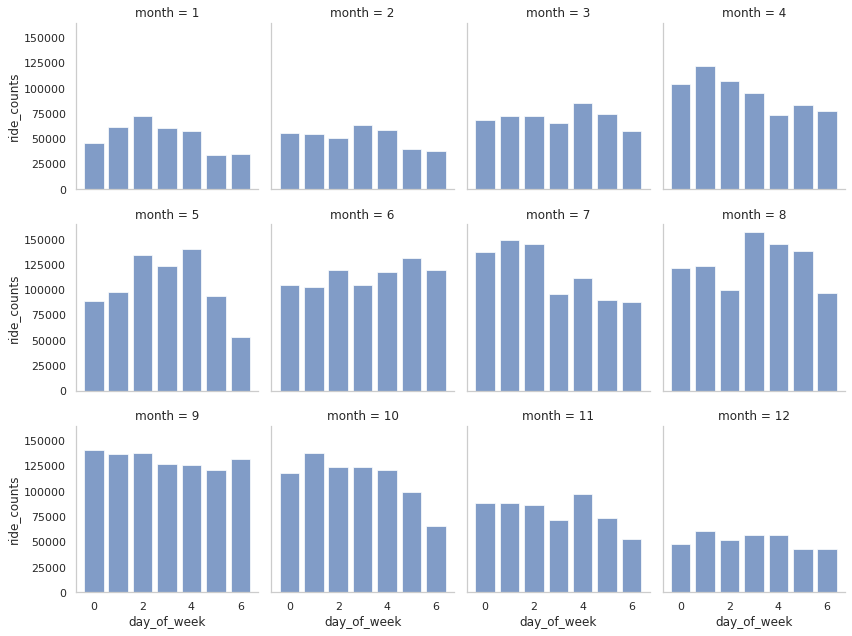

In [138]:
# total volume by day of week and month of year
g = sns.FacetGrid(citibike_day_month, col="month", col_wrap=4) #  row="month")
g = g.map(plt.bar, "day_of_week", "ride_counts", color='b', alpha=0.7)

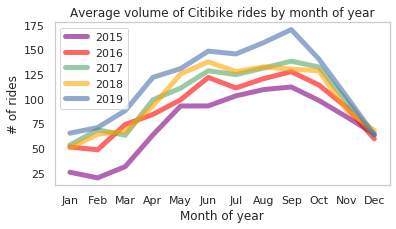

In [47]:
# average volume of citibike rides by month of year
citibike_monthly = citibike_df.groupby(['month','year'])['ride_counts_clean'].mean().reset_index()

#fig, ax = plt.subplots(nrows=1, ncols=1)

fig = plt.figure(figsize=(6,3));
ax = fig.add_subplot(1, 1, 1) # nrows, ncols, index

plt.plot(np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), np.array(citibike_monthly[citibike_monthly.year==2015].ride_counts_clean), color='purple', alpha=0.6, linewidth=5.0)

plt.plot(np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), np.array(citibike_monthly[citibike_monthly.year==2016].ride_counts_clean), color='red', alpha=0.6, linewidth=5.0)

plt.plot(np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), np.array(citibike_monthly[citibike_monthly.year==2017].ride_counts_clean), color='g', alpha=0.6, linewidth=5.0)

plt.plot(np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), np.array(citibike_monthly[citibike_monthly.year==2018].ride_counts_clean), color='orange', alpha=0.6, linewidth=5.0)

plt.plot(np.array(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']), np.array(citibike_monthly[citibike_monthly.year==2019].ride_counts_clean), color='b', alpha=0.6, linewidth=5.0)


ax = plt.gca()

#ax.set_facecolor('whitesmoke')
plt.title('Average volume of Citibike rides by month of year')
plt.xlabel('Month of year')
plt.ylabel('# of rides')
plt.legend(['2015', '2016', '2017', '2018', '2019']);